<h1>C4 Solution</h1>

<h3>Install and import</h3>

In [1]:
%%capture
import sys
!{sys.executable} -m pip install smdebug torch torchvision tqdm

In [2]:
import os
import boto3
import sagemaker
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics

<h3>Get the data and copy it to S3</h3>

In [3]:
%%capture
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip
!aws s3 cp dogImages s3://udacityproject04/ --recursive

<h3>Set up parameters, estimator, and tuner</h3>

In [4]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [5]:
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='pytorch_dog_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=2,  # you once have one ml.g4dn.xlarge instance available
    objective_type=objective_type
)

<h3>Fit the tuner</h3>

In [7]:
os.environ['SM_CHANNEL_TRAINING']='s3://udacityproject04/'
os.environ['SM_MODEL_DIR']='s3://udacityproject04/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://udacityproject04/output/'

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [ ]:
tuner.fit({'training': "s3://udacityproject04/"})

<h3>Describe the tuning results</h3>


In [9]:
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name='pytorch-training-230623-2122')

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

batch_size  learning_rate                            TrainingJobName  \
0      "128"       0.030806  pytorch-training-230623-2122-002-34738575   
1       "64"       0.001396  pytorch-training-230623-2122-001-74837e7f   

  TrainingJobStatus  FinalObjectiveValue         TrainingStartTime  \
0         Completed                581.0 2023-06-23 21:47:09+00:00   
1         Completed                108.0 2023-06-23 21:23:49+00:00   

            TrainingEndTime  TrainingElapsedTimeSeconds  
0 2023-06-23 22:06:20+00:00                      1151.0  
1 2023-06-23 21:43:55+00:00                      1206.0

## Imp: If kernel dies, how to continue from a completed training job

In [8]:
#BetterTrainingJobName='pytorch-training-230623-2122-001-74837e7f'
#my_estimator = sagemaker.estimator.Estimator.attach(BetterTrainingJobName)
#my_estimator.hyperparameters()
#best_estimator=my_estimator

<h3>Prepare to perform Training on Best Estimator</h3>

In [10]:
best_estimator=tuner.best_estimator()


2023-06-23 21:47:08 Starting - Preparing the instances for training
2023-06-23 21:47:08 Downloading - Downloading input data
2023-06-23 21:47:08 Training - Training image download completed. Training in progress.
2023-06-23 21:47:08 Uploading - Uploading generated training model
2023-06-23 21:47:08 Completed - Resource reused by training job: pytorch-training-230623-2122-002-34738575


In [11]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"64"',
 'learning_rate': '0.0013962824190236237',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_dog_hpo-2023-06-23-21-22-24-782"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-677336907491/pytorch_dog_hpo-2023-06-23-21-22-24-782/source/sourcedir.tar.gz"'}

In [12]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['learning_rate']}
hyperparameters

{'batch_size': 64, 'learning_rate': '0.0013962824190236237'}

In [13]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [14]:
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


<h2>Creating an Estimator</h2>

In [15]:
#adjust this cell to accomplish multi-instance training
estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='dog-pytorch',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [16]:
estimator.fit({"training": "s3://udacityproject04/"}, wait=True)

Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: dog-pytorch-2023-06-23-22-16-16-335


<h2>Creating an Estimator - Multi-Instance Training,</h2>

In [17]:
###in this cell, create and fit an estimator using multi-instance training
#adjust this cell to accomplish multi-instance training
estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='dog-pytorch',
    role=role,
    instance_count=4,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [18]:
estimator.fit({"training": "s3://udacityproject04/"}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: dog-pytorch-2023-06-23-22-16-25-288


Using provided s3_resource


In [27]:
job_name = estimator._current_job_name
debug_artifacts_path = estimator.latest_job_debugger_artifacts_path()
print('Job name: {} and Debug Path: {}'.format(job_name, debug_artifacts_path))

Job name: dog-pytorch-2023-06-23-22-16-25-288 and Debug Path: s3://sagemaker-us-east-1-677336907491/dog-pytorch-2023-06-23-22-16-25-288/debug-output


<h2>Deployment</h2>

In [28]:
model_location=estimator.model_data

In [29]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor


In [30]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [31]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='infernce2.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [32]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-677336907491/dog-pytorch-2023-06-23-22-16-25-288/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-677336907491/pytorch-inference-2023-06-23-22-48-18-734/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2023-06-23-22-48-32-746
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-06-23-22-48-33-467
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-06-23-22-48-33-467


-----!

In [33]:
import requests
#request_dict={ "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" }
request_dict={ "url": "https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/20113314/Carolina-Dog-standing-outdoors.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

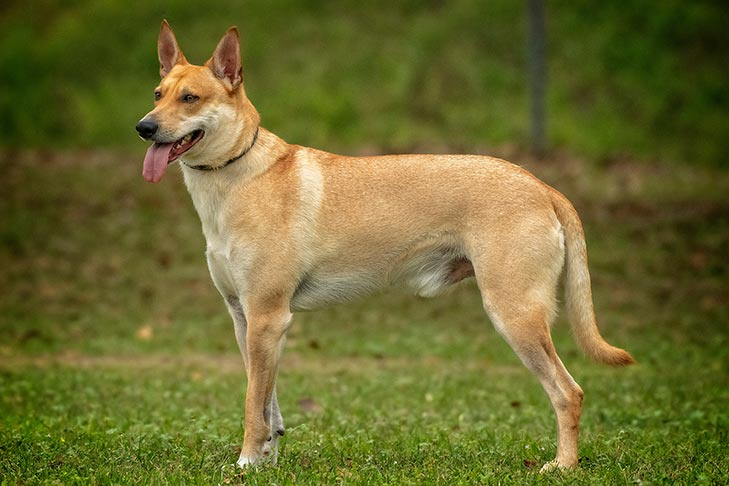

In [34]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [35]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [36]:
import json
response2=predictor.predict(json.dumps(request_dict), initial_args={"ContentType": "application/json"})

In [37]:
type(response2[0][0])

float

In [38]:
response2[0]

[-6.174785137176514,
 -3.825085401535034,
 -3.5156660079956055,
 -1.3347411155700684,
 -3.5546412467956543,
 -5.394352436065674,
 -1.4918313026428223,
 0.5472356677055359,
 -4.883398532867432,
 -0.9282864332199097,
 0.7223137021064758,
 -1.4913336038589478,
 -1.7713611125946045,
 1.4947353601455688,
 -3.0885863304138184,
 -3.5403783321380615,
 -8.624714851379395,
 -1.5214909315109253,
 -3.122654914855957,
 1.46768319606781,
 -3.6551156044006348,
 -1.4709088802337646,
 -4.9427642822265625,
 -4.822177886962891,
 -2.6100404262542725,
 -5.682880401611328,
 -1.3724743127822876,
 -1.724255919456482,
 -2.560716390609741,
 -1.4299689531326294,
 -1.7895772457122803,
 -1.1096901893615723,
 -4.91541862487793,
 -3.4278502464294434,
 -4.572039604187012,
 -4.189247131347656,
 -2.96058988571167,
 -1.8789058923721313,
 -0.29866185784339905,
 -3.7349183559417725,
 -1.3103678226470947,
 -2.311067581176758,
 1.9662245512008667,
 -1.8154867887496948,
 -2.205169677734375,
 -6.385608196258545,
 -0.631987690

In [39]:
import torch
import numpy as np
np.argmax(response, 1)

array([42])

In [40]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2023-06-23-22-48-33-467
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2023-06-23-22-48-33-467
